## Bayesian Logistic Lasso Regression

Bayesian Lasso regression is an extension of traditional Lasso regression into the Bayesian framework. In traditional Lasso (Least Absolute Shrinkage and Selection Operator) regression, regularization is introduced by adding a penalty equivalent to the absolute value of the magnitude of coefficients. This helps in reducing overfitting by shrinking some coefficients to zero, thereby performing variable selection. In the Bayesian context, the Lasso penalty is interpreted as placing a Laplace prior on the regression coefficients. This prior is equivalent to a double exponential distribution centered at zero, which encourages sparsity in the coefficients—similar to the Lasso penalty in frequentist regression.

### Import modules

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import arviz as az
import seaborn as sns
import time

The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.


### Data overview

#### Load the data

In [2]:
data = pd.read_csv('heart_statlog_cleveland_hungary_final.csv')
data

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1185,45,1,1,110,264,0,0,132,0,1.2,2,1
1186,68,1,4,144,193,1,0,141,0,3.4,2,1
1187,57,1,4,130,131,0,0,115,1,1.2,2,1
1188,57,0,2,130,236,0,2,174,0,0.0,2,1


In [3]:
# Check for any missing values
print(data.isnull().sum())

age                    0
sex                    0
chest pain type        0
resting bp s           0
cholesterol            0
fasting blood sugar    0
resting ecg            0
max heart rate         0
exercise angina        0
oldpeak                0
ST slope               0
target                 0
dtype: int64


The dataset utilized in this analysis is focused on identifying the presence of heart disease based on various clinical parameters that are collected from 1189 patients with no missing values. The dataset consists of a mixture of binary, nominal, and numeric variables that collectively contribute to the diagnostic analysis of heart disease. Each attribute plays a specific role in the overall diagnosis, and the Bayesian logistic regression model utilizes these features to predict the probability of heart disease presence, considering the influence of each factor. This comprehensive dataset allows for robust analysis and modeling, making it suitable for applying advanced statistical techniques like Bayesian inference with regularization to handle multicollinearity and improve prediction accuracy.

##### Covariates
1. **Age**: The age of the individual in years. This is a numeric attribute that can provide insights into the risk associated with age for heart diseases.
2. **Sex**: A binary indicator for the sex of the individual (1 = male, 0 = female), which is relevant as some heart conditions are more prevalent in one gender.
3. **Chest Pain Type**: Categorized into four types:
   - **1**: Typical angina
   - **2**: Atypical angina
   - **3**: Non-anginal pain
   - **4**: Asymptomatic
   This attribute is nominal and describes the type of chest pain experienced by the individual, which is a critical symptomatic indicator of heart disease.
4. **Resting Blood Pressure (resting bp s)**: The resting blood pressure in mm Hg, a key cardiovascular health indicator.
5. **Serum Cholesterol (cholesterol)**: Measured in mg/dl, this numeric attribute indicates cholesterol levels, which are linked to cardiovascular risk.
6. **Fasting Blood Sugar**: Indicates whether fasting blood sugar is above 120 mg/dl (1 = true, 0 = false), classifying it as binary. High fasting blood sugar can be an indicator of diabetic complications related to heart health.
7. **Resting Electrocardiogram Results (resting ecg)**: Categorized into three types:
   - **0**: Normal
   - **1**: Having ST-T wave abnormality
   - **2**: Showing probable or definite left ventricular hypertrophy by Estes' criteria
   This nominal attribute provides insights into heart electrical activity and potential underlying heart conditions.
8. **Maximum Heart Rate Achieved (max heart rate)**: A numeric attribute indicating the highest heart rate achieved by an individual, which can be a marker of cardiovascular fitness and function.
9. **Exercise Induced Angina (exercise angina)**: Binary (1 = yes, 0 = no). This indicates whether exercise induces angina, a symptom of significant coronary artery disease.
10. **Oldpeak**: Numeric, measures the ST depression induced by exercise relative to rest, an indicator of myocardial ischemia.
11. **ST Slope (ST slope)**: The slope of the peak exercise ST segment, an important marker in diagnosing myocardial ischemia, categorized into:
    - **1**: Upsloping
    - **2**: Flat
    - **3**: Downsloping

##### Target Variable
- **Class (target)**: Binary (1 = heart disease, 0 = Normal). This is the outcome variable indicating the presence or absence of heart disease.

#### Data exploration

In [4]:
data.describe()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
count,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000
mean,53.720168,0.763866,3.232773,132.153782,210.363866,0.213445,0.698319,139.732773,0.387395,0.922773,1.624370,0.528571
std,9.358203,0.424884,0.935480,18.368823,101.420489,0.409912,0.870359,25.517636,0.487360,1.086337,0.610459,0.499393
min,28.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000,0.000000
25%,47.000000,1.000000,3.000000,120.000000,188.000000,0.000000,0.000000,121.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,4.000000,130.000000,229.000000,0.000000,0.000000,140.500000,0.000000,0.600000,2.000000,1.000000
75%,60.000000,1.000000,4.000000,140.000000,269.750000,0.000000,2.000000,160.000000,1.000000,1.600000,2.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,1.000000


The input variables include both categorical and continuous variables that vary in scale. To facilitate further analysis, the continuous columns will be standardized. Standardizing input variables is crucial as it helps to mitigate issues related to scale dependence in models, improves algorithm efficiency, and ensures fairness in how features contribute to the predictions of a model.

##### Data preprocessing

In [5]:
# Assuming 'class' is the target variable based on the documentation
y = data['target'].values
X = data.drop('target', axis=1)

In [6]:
std_cols = ['age', 'resting bp s', 'cholesterol','max heart rate','oldpeak']
X_std_col = X[std_cols]
X_remain=X.drop(std_cols,axis=1)
X_normalized = (X_std_col - X_std_col.mean()) / X_std_col.std()
X_normalized=pd.concat([X_normalized, X_remain], axis=1)
X_normalized.head()

,age,resting bp s,cholesterol,max heart rate,oldpeak,sex,chest pain type,fasting blood sugar,resting ecg,exercise angina,ST slope
0,-1.466111,0.427149,0.775348,1.264507,-0.849435,1,2,0,0,0,1
1,-0.504388,1.515950,-0.299386,0.637490,0.071089,0,3,0,0,0,2
2,-1.786686,-0.117252,0.716188,-1.635448,-0.849435,1,2,0,1,0,1
3,-0.611246,0.318269,0.035852,-1.243562,0.531351,0,4,0,0,1,2
4,0.029902,0.971549,-0.151487,-0.694922,-0.849435,1,3,0,0,0,1


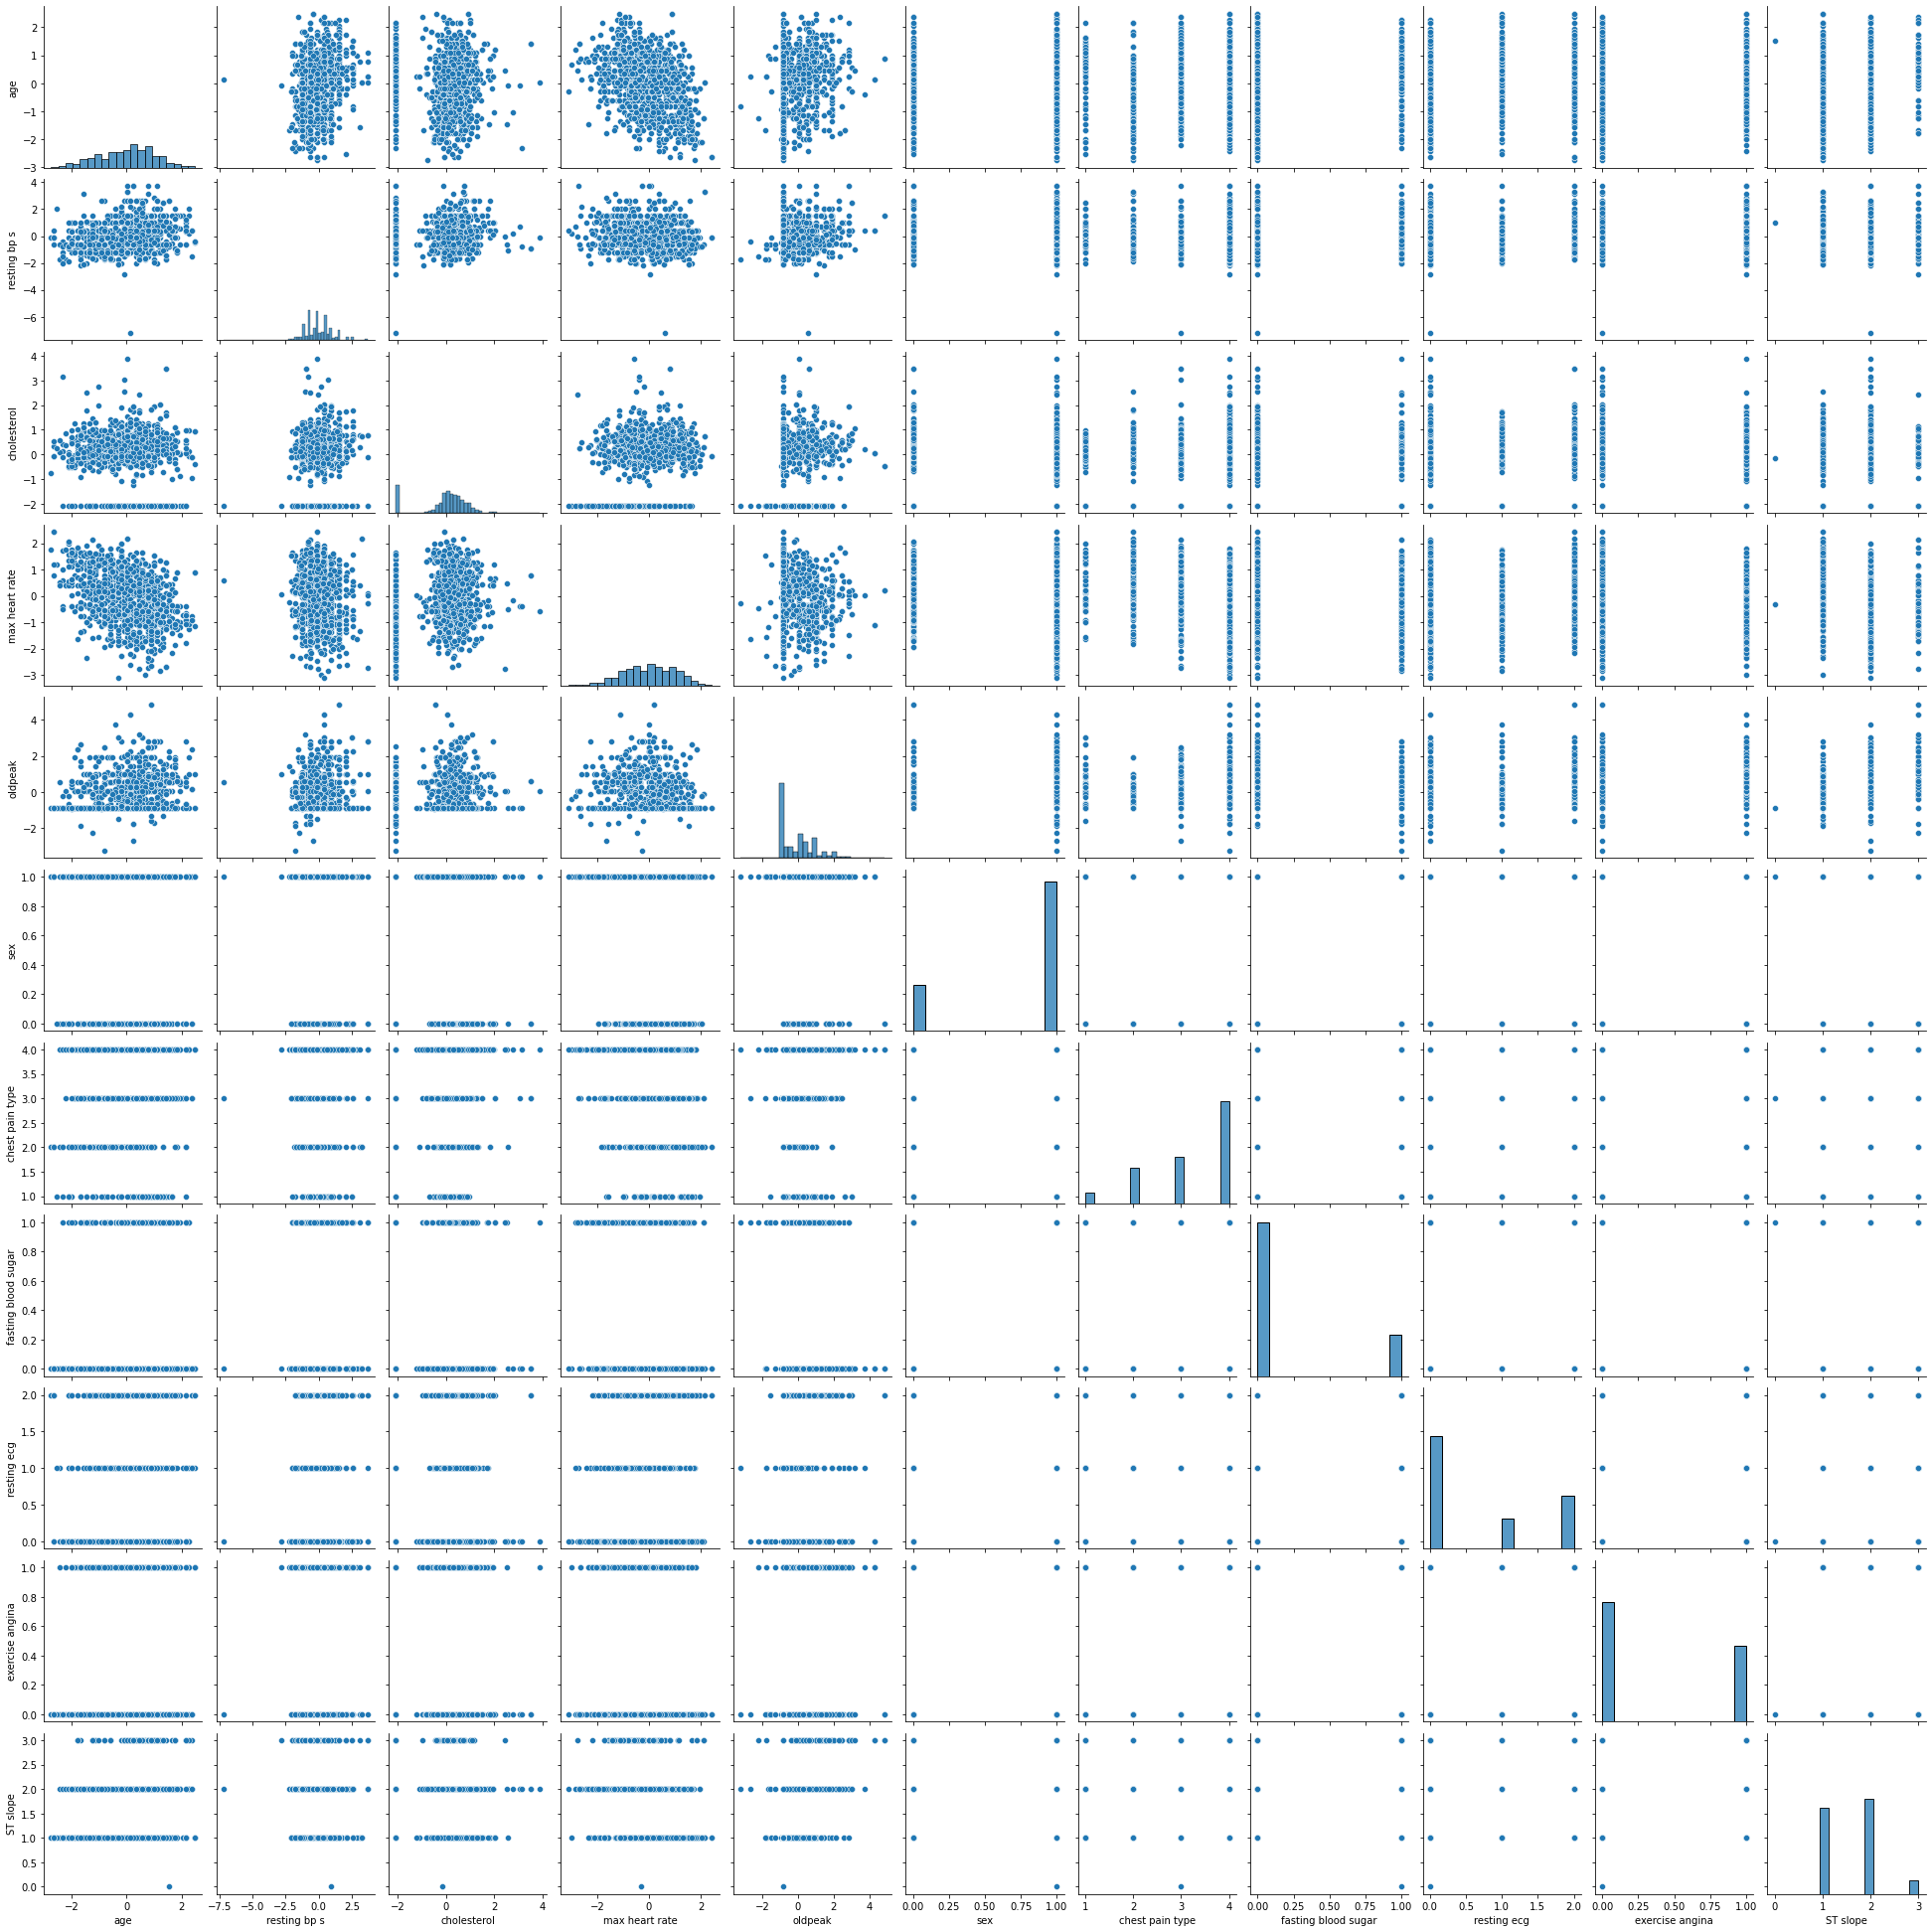

In [15]:
## pairplots
sns.pairplot(X_normalized)

Check multicollinearity among continuous varaibles through Variance Inflation Factor(VIF).

In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

data_num=X_normalized[std_cols]
vif_data = pd.DataFrame() 
vif_data["feature"] = data_num.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(data_num.values, i) 
                          for i in range(len(data_num.columns))] 
  
print(vif_data)

          feature       VIF
0             age  1.260222
1    resting bp s  1.100167
2     cholesterol  1.085844
3  max heart rate  1.246588
4         oldpeak  1.099390


In [ ]:
Base on the VIF value above, there is no variable has VIF greater than five, which indicates no multicollinearity among the variables.

### Bayesian Logistic Lasso regression model setup (pymc3)

The Bayesian logistic model was implemented using PyMC3, incorporating a Lasso (L1) prior to perform regularization. This is particularly useful in preventing overfitting and enhancing model generalization, especially in datasets with many predictors. The following Bayesian model generates four chains for each parameter. 

An additional data preprocessing step is necessary, as we are employing Lasso for feature selection. To ensure effectiveness, all features must be standardized, including binary features. This recommendation aligns with the guidelines provided in 'The Elements of Statistical Learning' by Tibshirani et al., available at: http://web.stanford.edu/~hastie/ElemStatLearn/.

In [24]:
X_normalized = (X - X.mean()) / X.std()

In [ ]:
start_time = time.time()

In [36]:
with pm.Model() as model:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    betas = pm.Laplace('betas', mu=0, b=1, shape=X_normalized.shape[1])

    # Predicted probability of heart disease
    logits = alpha + tt.dot(X_normalized, betas)
    p = pm.Deterministic('p', pm.math.sigmoid(logits))
    
    # Likelihood (Bernoulli distributed observations)
    Y_obs = pm.Bernoulli('Y_obs', p=p, observed=y)

    # Inference
    trace = pm.sample(1000, tune=500, return_inferencedata=False)

The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, alpha]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 15 seconds.


In [ ]:
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Bayesian logistic Lasso regression model fitting time: {elapsed_time:.3f} seconds")

### Model Diagnostics

Trace plots and posterior predictive checks were generated to assess the convergence and fit of the Bayesian model. In the trace plots below, the four chains for each parameter are well-mixed and convergent.

Got error No model on context stack. trying to find log_likelihood in translation.
/users/PES0644/zhang2hc/.local/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
/users/PES0644/zhang2hc/.local/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a mo

array([[<AxesSubplot:title={'center':'betas'}>,
        <AxesSubplot:title={'center':'betas'}>]], dtype=object)

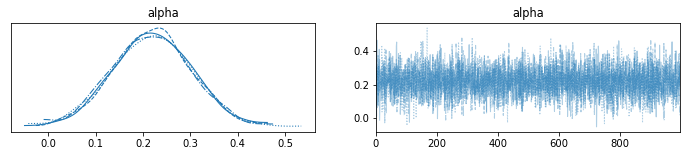

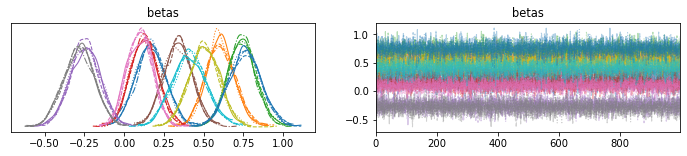

In [37]:
# Convert trace to InferenceData object for diagnostics
idata = az.from_pymc3(trace)

# Check the trace and convergence diagnostics
az.plot_trace(trace, var_names=['alpha'])
az.plot_trace(trace, var_names=['betas'])

In [38]:
az.summary(idata, round_to=3, var_names=['alpha', 'betas'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.219,0.083,0.059,0.369,0.001,0.001,5493.991,3408.360,1.000
betas[0],0.166,0.093,-0.005,0.345,0.001,0.001,5062.752,3390.569,1.000
betas[1],0.605,0.091,0.435,0.776,0.001,0.001,5121.603,3010.177,1.003
betas[2],0.741,0.089,0.570,0.907,0.001,0.001,4427.330,3231.717,1.001
betas[3],0.126,0.086,-0.029,0.292,0.001,0.001,5217.996,2647.172,1.000
betas[4],-0.247,0.095,-0.423,-0.068,0.001,0.001,5530.581,3327.882,1.001
betas[5],0.337,0.091,0.180,0.519,0.001,0.001,5198.856,3273.319,1.002
betas[6],0.099,0.079,-0.053,0.242,0.001,0.001,5208.193,3342.243,1.002
betas[7],-0.283,0.096,-0.469,-0.110,0.001,0.001,4551.709,3279.754,1.001
betas[8],0.503,0.095,0.327,0.683,0.001,0.001,5567.161,3522.317,1.000


After trying different "b" values in Laplace prior, no coefficients are shrunk to zero in this LASSO regression, which indicates all varaiables shoule be retained.

### Predictive Performance

The model achieved an accuracy of approximately 83.36%. This indicates a relatively high level of accuracy in predicting the presence of heart disease using the given predictors and Bayesian logistic regression model. The confusion matrix shows the model performs better in predicting existing heart disease.

/users/PES0644/zhang2hc/.local/lib/python3.9/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


<AxesSubplot:xlabel='Y_obs / Y_obs'>

/usr/local/python/3.9-2022.05/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


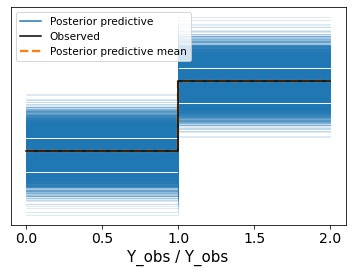

In [39]:
# Posterior predictive checks
ppc = pm.sample_posterior_predictive(trace, model=model)
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model))

In [40]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

# Calculate predicted probabilities using the mean of the posterior
betas_mean = np.mean(trace['betas'], axis=0)
alpha_mean = np.mean(trace['alpha'], axis=0)
logits = alpha_mean + np.dot(X_normalized, betas_mean)
probs = 1 / (1 + np.exp(-logits))

# Predict class labels based on a threshold of 0.5
y_pred = (probs > 0.5).astype(int)

# Compute confusion matrix
conf_matrix = confusion_matrix(y, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Optionally print accuracy or other classification metrics
accuracy = accuracy_score(y, y_pred)
print("Accuracy:", accuracy)

Confusion Matrix:
 [[462  99]
 [ 99 530]]
Accuracy: 0.8336134453781513


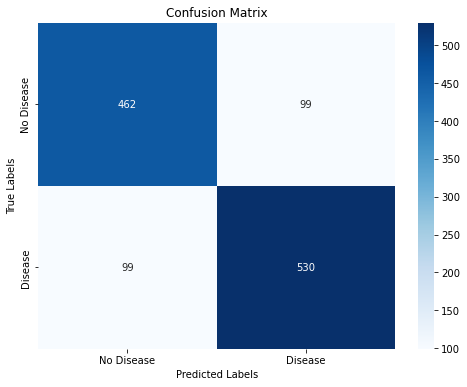

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Conclusion

The Bayesian logistic regression model with a Lasso prior has shown to be effective in predicting heart disease from the dataset, with good diagnostic checks and satisfactory predictive performance. This approach leverages the benefits of Bayesian inference, such as handling uncertainty and incorporating prior knowledge, while the Lasso prior helps in managing variable selection and the fitted results indicates all variables should be take into consideration in determining the presence of heart disease.